In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import pylab as plt
import pandas as pd
import tensorflow as tf
import pickle

def gload(gsname):
    with tf.io.gfile.GFile(gsname, "rb") as file:
        obj = pickle.load(file)
    return obj

def load_precomp(basedir):
    Ms = gload(f'{basedir}/Mlist')
    ks = gload(f'{basedir}/ks')
    return Ms, ks

def load(name):
    return load_precomp(f'gs://hml-public/dd/{name}')

In [2]:
Ms, ks = load('cifar10-resnet18k-50k-adam')

## DATA FORMAT:
## M = Ms[{0, 1, 2}] : {0, 10, 20}% label noise
## M['Test Error'][]

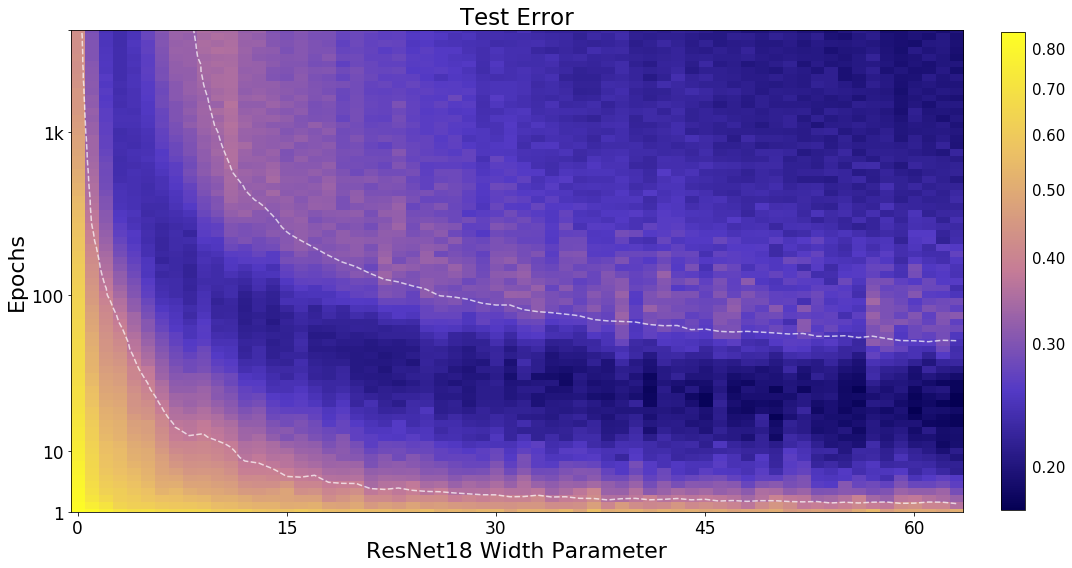

In [11]:
def plot_ocean(Ms, ks, base, sup_title='', title = 'Test Error',
               contours=[0.15, 0.5],
               x_ticks_fs = 17, y_ticks_fs = 17, x_label_fs = 22, y_label_fs = 22, cbar_fs = 15, title_fs = 23):
    
    def x_fmt(x):
        decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
        suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
        if x == 0:
            return str(0)
        for i, d in enumerate(decades):
            if np.abs(x) >= d:
                val = x/float(d)
                signf = len(str(val).split(".")[1])
                if signf == 0:
                    return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
                else:
                    if signf == 1:
                        if str(val).split(".")[1] == "0":
                            return '{val:d}{suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                    tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                    return tx.format(val=val, suffix=suffix[i])
        return x

    # Get steps grid, number of parameters
    
    max_steps = Ms[title].shape[1]
    eps = np.unique(np.array(base**np.arange(0, np.log(max_steps)/np.log(base)), dtype=int)-1)

    # Colormap
    with open('custom_colormaps/colormap_inferno_strong_1.txt', 'r') as f:
        a = f.read()
    C = [list(map(int, val.split(' '))) for val in a.split('\n')[:-1]]
        
    cm = mpl.colors.ListedColormap(np.array(C)/255.0)

    # Start plotting
    fig = plt.figure(figsize=(15, 8))
    ax = fig.gca()
    

    M = Ms[title][:, eps].T

    if title == 'Test Error':
        im = ax.imshow(M, cmap=cm, norm=colors.LogNorm(vmin=np.min(M), vmax=np.max(M)),
                      aspect='auto',
                   interpolation='none')  
    elif title == 'Train Error':
        im = ax.imshow(M, cmap=cm, norm=colors.Normalize(vmin=np.min(M), vmax=0.8),
                       aspect='auto',
                   interpolation='none')

    if contours is not None:
        ax.contour(Ms['Train Error'][:, eps].T, levels=contours, colors='white', linestyles='dashed', alpha=0.7)

    
    # Y-axis
    ten_powers = 10 ** np.arange(10) - 1
    ten_powers = ten_powers[ten_powers < max_steps]

    yvals = eps
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(yvals-val))]
    
    ax.set_yticks(np.arange(len(eps)))
    ax.set_yticks(indices + [len(eps)-1])
    ax.set_yticklabels([x_fmt(val+1) for val in ten_powers] + [''], fontsize=y_ticks_fs)
    ax.set_ylabel('Epochs', fontsize=y_label_fs)
    ax.invert_yaxis()

    # X-axis
    x_idx = np.arange(M.shape[1])[::15]
    x_vals = x_idx
    x_labs = ['%d' % (n) for n in x_vals]
    ax.set_xticks(x_idx)
    ax.set_xticklabels(x_labs, fontsize=x_ticks_fs)
    ax.set_xlabel('ResNet18 Width Parameter', fontsize=x_label_fs)

    
    # Colorbar
    ticks = np.linspace(0.0, 0.8, 9)
    cbar = fig.colorbar(im, fraction=0.025, pad=0.04, ticks=ticks)
    #cbar.set_ticks(ticks)
    
    cbar.ax.get_yaxis().set_major_formatter(matplotlib.ticker.NullFormatter())
    cbar.ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
    cbar.ax.minorticks_off()
    
    cbar.ax.set_yticklabels(['%.2f'%val for val in ticks])
    
    cbar.ax.tick_params(labelsize=cbar_fs) 
    cbar.ax.tick_params(right=False)

    ax.set_title(title, fontsize=title_fs)
        
    plt.tight_layout()
    fig.suptitle(sup_title, fontsize=title_fs)
    return fig


fig = plot_ocean(Ms[2], ks, title='Test Error', base = 1.1)

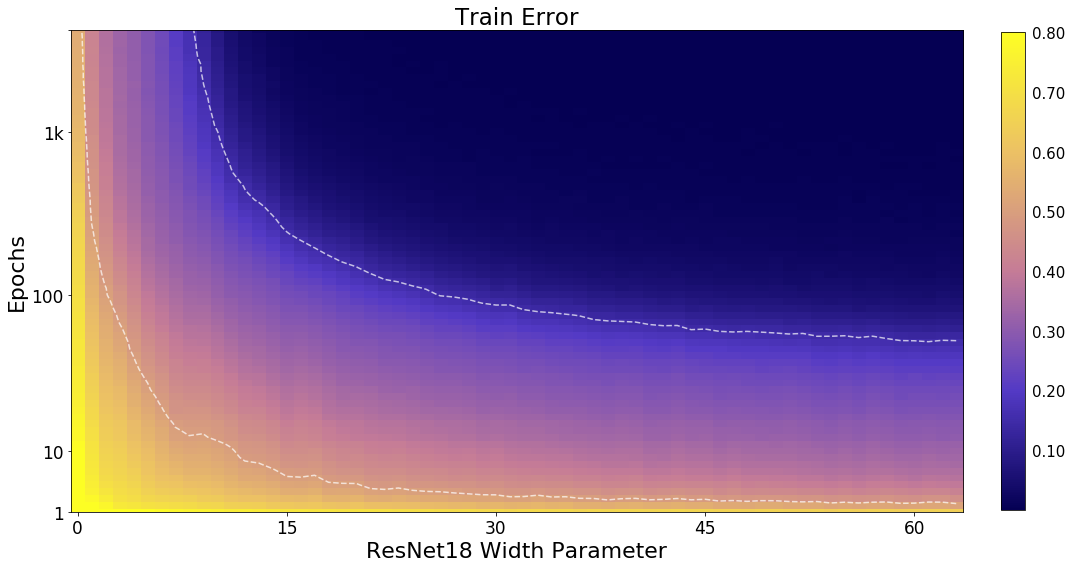

In [12]:
fig = plot_ocean(Ms[2], ks, title='Train Error', base = 1.1)